# 1. AAL atlas

In [1]:
import sys

sys.path.append('../')

In [2]:
from src.utils import initialize_experiment

experiment = initialize_experiment()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/etokone/fmri-la5c-study/13f4c3ae2f5145729ef7071837e472c2



In [2]:
import os 

from src.utils import calc_all_sub_ts

from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import datasets
from bids.layout import BIDSLayout

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
# Base directory for fmriprep output
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout = BIDSLayout(fmriprep_dir,
                        config=['bids', 'derivatives'])

In [4]:
atlas_aal = datasets.fetch_atlas_aal()


Dataset created in /home/neuro/nilearn_data/aal_SPM12



 ...done. (2 seconds, 0 min)
Extracting data from /home/neuro/nilearn_data/aal_SPM12/a2fc9a441ebe10d638e4a74b1d3c1dac/aal_for_SPM12.tar.gz..... done.


In [ ]:
params = {
    'parcel_file': atlas_aal['maps'],
    'confounds': ['trans_x', 'trans_y', 'trans_z', 
                  'rot_x', 'rot_y', 'rot_z', 
                  'white_matter', 'csf', 'global_signal'],
    'high_pass': 0.009,
    'low_pass': 0.08,
    'detrend': True,
    'standardize': True,
    'tr_drop': 4
    
}
experiment.log_parameters(params)

In [8]:
from nilearn import input_data

masker = input_data.NiftiLabelsMasker(labels_img=params['parcel_file'],
                                      standardize=params['standardize'],
                                      memory='nilearn_cache',
                                      detrend=params['detrend'],
                                      low_pass=params['low_pass'],
                                      high_pass=params['high_pass'],
                                      t_r=2)

In [9]:
ctrl_subjects_raw, schz_subjects_raw, labels_list = calc_all_sub_ts(layout, params, masker)

  0%|                                                    | 0/17 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/nifti_labels_masker.py:486: UserWarning: Persisting input arguments took 1.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)
100%|███████████████████████████████████████████| 17/17 [00:52<00:00,  3.10s/it]


Control group connectivity matrix shape (7, 116, 116)


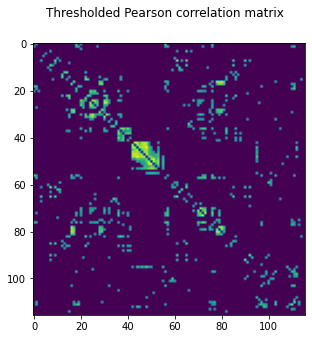

In [11]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance

covariance_estimator = EmpiricalCovariance()
connectivity_correlation = ConnectivityMeasure(kind="correlation", cov_estimator=covariance_estimator)

# Calculate pearson correlation
R_ctrl = connectivity_correlation.fit_transform(ctrl_subjects_raw)
print(f'Control group connectivity matrix shape {R_ctrl.shape}')

# Tresholding
R_tresholded = R_ctrl[0].copy()
np.fill_diagonal(R_tresholded, 0)
R_tresholded[R_tresholded < 0.5] = 0.0

# Visualise
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.suptitle("Thresholded Pearson correlation matrix")
ax1.imshow(R_tresholded)
plt.show()

#experiment.log_confusion_matrix(matrix=R_tresholded)

## Network visualization

In [12]:
# ROIs coordinates
coordinates = nplot.find_parcellation_cut_coords(labels_img=atlas_aal["maps"])

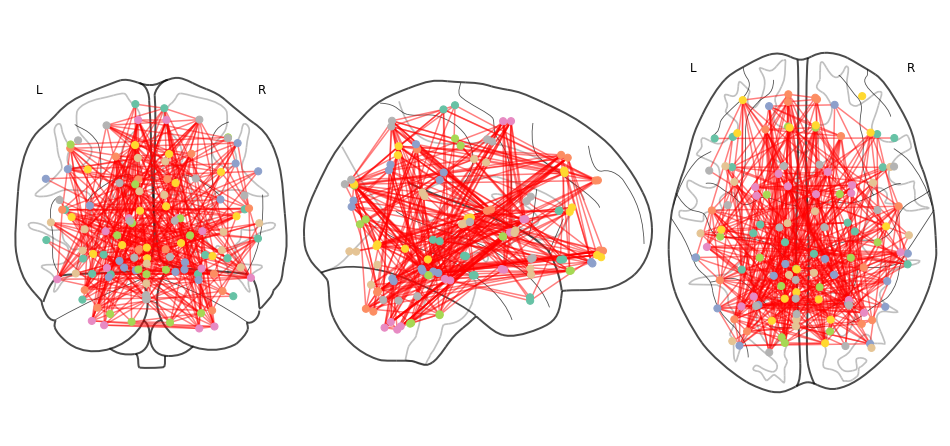

In [13]:
# nilearn graph drawing
fig = plt.figure(figsize=(13,6))
edge_options = {"color": "r", "linewidth": 1.5, "alpha": 0.5}
nplot.plot_connectome(R_tresholded, coordinates, figure=fig, edge_kwargs=edge_options)

In [14]:
import networkx as nx
#import diagram2vec

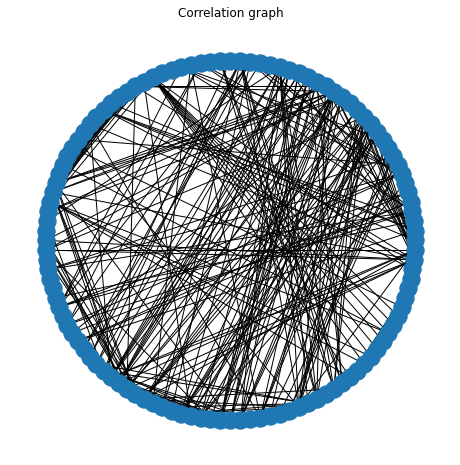

In [15]:
# matplotlib graph drawing
fig, (ax1) = plt.subplots(1, 1, figsize=(8,8))
ax1.set_title("Correlation graph")
nx.draw_shell(nx.from_numpy_array(R_tresholded), ax=ax1)
plt.show()

## Network analysis

### Graph-theoretic

[networkx docs](https://networkx.org/documentation/stable/index.html)

<img src="./static/graph_features.png"/>

We have connectivity matrix, and we want to create graph

In [16]:
G = nx.from_numpy_array(R_tresholded)

### Node degree

The degree of a node is the number of edges connected to the node.

For directed network, we check in and out degrees 

In [17]:
degree = np.array([degree[1] for degree in nx.degree(G)])
degree

array([ 5, 10,  1,  4,  1,  1,  2,  9,  2,  6,  3,  4,  5,  3,  7, 10, 11,
       11, 10,  5, 15,  5, 10,  4, 17, 12, 12,  7, 10,  9, 19,  8, 10,  4,
        2,  4, 17, 12, 10,  3, 10,  8, 10,  7, 11, 11, 11, 12, 15, 13, 11,
        9,  7, 11,  0,  8, 12, 14,  1,  5,  5,  9,  3,  3,  3,  9,  5,  4,
        4,  2, 12, 13, 16, 11,  1,  8, 23,  8,  9, 15,  7,  8, 11,  0,  4,
        7, 10,  1,  3,  0,  6,  4,  5,  1,  1, 11,  3,  9,  4,  6,  4,  5,
        2,  6,  0,  2,  1,  0,  3,  3, 11, 15,  8,  4,  2,  0])

In [18]:
degree.shape

(116,)

### Average neighbor degree 

$$k_{nn, i} = \frac{1}{| N(i) |} \displaystyle\sum_{j\in\ N(i)} k_j$$

where **N(i)** are the neighbors of node **i**,

and **k_j** is the degree of node **j** which belongs to **N(i)**

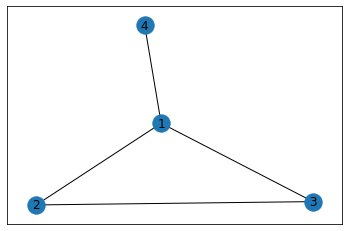

In [19]:
G_ex = nx.Graph()
G_ex.add_edges_from([(1, 2), (2, 3), (1, 3), (1, 4)])
nx.draw_networkx(G_ex)
plt.show()

In [20]:
neighbor_degree_avg_ex = np.array(list(nx.average_neighbor_degree(G_ex).values()))
neighbor_degree_avg_ex

array([1.66666667, 2.5       , 2.5       , 3.        ])

In [21]:
first_nn = 1/3 * (2 + 2 + 1)
first_nn

1.6666666666666665

In [22]:
neighbor_degree_avg = np.array(list(nx.average_neighbor_degree(G).values()))
neighbor_degree_avg

array([14.        , 11.8       , 15.        ,  7.75      ,  1.        ,
        1.        ,  4.        ,  5.88888889,  8.        ,  7.        ,
        2.        ,  5.        ,  6.8       ,  4.33333333,  9.71428571,
        8.5       , 11.27272727, 10.63636364, 12.1       , 11.6       ,
       12.8       , 10.4       , 10.3       ,  8.75      , 12.11764706,
       12.        , 11.16666667, 14.        , 10.4       , 11.22222222,
       12.57894737, 12.        , 12.6       ,  6.5       ,  4.5       ,
        3.75      , 11.64705882, 10.83333333,  9.8       , 13.        ,
       11.3       , 10.75      , 11.        , 11.85714286, 10.90909091,
       10.90909091, 11.        , 10.58333333,  9.53333333, 10.30769231,
       10.81818182,  9.88888889, 11.28571429, 10.72727273,  0.        ,
       10.25      , 11.25      , 13.        ,  5.        ,  5.4       ,
        6.        ,  6.22222222,  3.33333333,  5.33333333,  7.        ,
        6.11111111,  4.6       ,  5.25      , 12.25      ,  4.5 

### Centralities

- **Betweenness centrality** is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another.

- The algorithm calculates unweighted shortest paths between all pairs of nodes in a graph. Each node receives a score, based on the number of shortest paths that pass through the node. Nodes that more frequently lie on shortest paths between other nodes will have higher betweenness centrality scores.

$$C_{B}(v) = \sum_{s, t \in V}\frac{\sigma(s,t|v)}{\sigma(s,t)}$$

**where** $$V$$ is the set of nodes, $$\sigma(s, t)$$ is the number of shortest **(s, t)**-paths, and $$\sigma(s, t|v)$$ is the number of those paths passing through some node **v** other than **s, t**. 

In [23]:
centrality_betweenness = np.array(list(nx.betweenness_centrality(G).values()))
centrality_betweenness

array([1.27129418e-04, 7.11832011e-03, 0.00000000e+00, 6.46817890e-03,
       0.00000000e+00, 0.00000000e+00, 2.38674004e-02, 4.10096137e-02,
       1.62206999e-02, 1.69965314e-02, 1.66285278e-02, 1.88205791e-02,
       1.95135230e-02, 1.89531100e-02, 9.18557787e-03, 3.58392325e-02,
       5.27955257e-03, 2.99815251e-02, 1.14037789e-02, 9.05645757e-05,
       2.64231605e-02, 9.76249240e-03, 2.26728101e-02, 3.31354708e-02,
       4.09756679e-02, 1.70780215e-02, 4.33143452e-02, 2.58137479e-03,
       1.62437474e-02, 4.67835634e-03, 6.26386406e-02, 2.11512578e-02,
       5.82007508e-02, 5.56586102e-02, 0.00000000e+00, 1.29356744e-02,
       5.26201853e-02, 9.69244597e-03, 2.39934341e-02, 0.00000000e+00,
       9.38681689e-03, 9.05580726e-03, 1.07592065e-02, 0.00000000e+00,
       1.31566826e-02, 1.31566826e-02, 3.94888187e-04, 6.00837843e-04,
       5.54993843e-02, 6.46489742e-03, 3.11836695e-03, 1.75222564e-02,
       6.13115223e-04, 4.06714304e-03, 0.00000000e+00, 6.72161793e-02,
      

In [24]:
max((val, idx) for idx, val in enumerate(centrality_betweenness))

(0.15460569612029815, 112)

In [30]:
atlas_aal.labels[112]

'Vermis_7'

### Closeness centrality

* In a connected graph, closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. 
* Thus, the more central a node is, the closer it is to all other nodes. 

$$C(u) = \frac{n - 1}{\sum_{v=1}^{n-1} d(v, u)}$$

where $$d(v, u)$$ is the shortest-path distance between *v* and *u*, and $$n$$ is the number of nodes in the graph.

In [32]:
centrality_closeness = np.array(list(nx.closeness_centrality(G).values()))
centrality_closeness

array([0.24164204, 0.26762506, 0.21227403, 0.22272153, 0.00869565,
       0.00869565, 0.18300831, 0.22575175, 0.2381735 , 0.23425064,
       0.15531439, 0.20442818, 0.23535821, 0.22025779, 0.24282078,
       0.26477798, 0.25204183, 0.27809084, 0.26619391, 0.23989523,
       0.27426039, 0.26061917, 0.26619391, 0.24642703, 0.29541995,
       0.28123311, 0.2844472 , 0.26268212, 0.26762506, 0.26690756,
       0.30077499, 0.26762506, 0.29986904, 0.26980087, 0.20740942,
       0.23703934, 0.29110094, 0.25926178, 0.27275759, 0.22834065,
       0.25658897, 0.2507721 , 0.20400927, 0.17905849, 0.20442818,
       0.20442818, 0.18068334, 0.18101186, 0.21832571, 0.19145485,
       0.19072131, 0.18999336, 0.18927095, 0.19072131, 0.        ,
       0.20442818, 0.27127118, 0.26762506, 0.17435468, 0.2232209 ,
       0.22372252, 0.23535821, 0.16989168, 0.19145485, 0.24827063,
       0.25268153, 0.24521311, 0.25140536, 0.25592936, 0.23152679,
       0.27654589, 0.2869064 , 0.28283103, 0.26548406, 0.13327

In [33]:
max((val, idx) for idx, val in enumerate(centrality_closeness))

(0.3160524499654934, 76)

In [34]:
atlas_aal.labels[76]

'Thalamus_L'

### Clustering coefficient

* **Clustering coefficient** is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterised by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes
* Two versions of this measure exist: the **global** and the **local**. The global version was designed to give an overall indication of the clustering in the network, whereas the local gives an indication of the embeddedness of single nodes.
* For unweighted graphs, the clustering of a node is the fraction of possible triangles through that node that exist
$$c_u = \frac{2 T(u)}{deg(u)(deg(u)-1)},$$ where $$T(u)$$ is the number of triangles through node **u**; $$deg(u)$$ is the degree of **u**.

In [35]:
clustering_coefficient_local = np.array(list(nx.clustering(G).values()))
clustering_coefficient_local

array([0.8       , 0.48888889, 0.        , 0.66666667, 0.        ,
       0.        , 0.        , 0.41666667, 0.        , 0.6       ,
       0.        , 0.33333333, 0.4       , 0.        , 0.52380952,
       0.4       , 0.50909091, 0.54545455, 0.55555556, 0.8       ,
       0.46666667, 0.6       , 0.51111111, 0.5       , 0.42647059,
       0.53030303, 0.39393939, 0.66666667, 0.57777778, 0.63888889,
       0.36842105, 0.57142857, 0.44444444, 0.16666667, 1.        ,
       0.33333333, 0.36029412, 0.43939394, 0.42222222, 1.        ,
       0.48888889, 0.42857143, 0.82222222, 1.        , 0.8       ,
       0.8       , 0.81818182, 0.75757576, 0.59047619, 0.71794872,
       0.78181818, 0.69444444, 0.95238095, 0.76363636, 0.        ,
       0.64285714, 0.45454545, 0.43956044, 0.        , 0.3       ,
       0.3       , 0.44444444, 0.33333333, 0.66666667, 0.33333333,
       0.44444444, 0.2       , 0.33333333, 0.5       , 0.        ,
       0.63636364, 0.62820513, 0.475     , 0.61818182, 0.     

###  Efficiency
* Efficiency of a network is a measure of how efficiently it exchanges information [1] and it is also called communication efficiency. The underlying idea (and main assumption) is that the more distant two nodes are in the network, the less efficient their communication will be. The concept of efficiency can be applied to both **local** and **global** scales in a network. 
* **On a global scale**, efficiency quantifies the exchange of information across the whole network where information is concurrently exchanged. 
* **The local efficiency** quantifies a network's resistance to failure on a small scale. That is the local efficiency of a node **i** characterizes how well information is exchanged by its neighbors when it is removed. 

In [42]:
local_efficiency = nx.local_efficiency(G)
local_efficiency 

0.5326050417570487

In [43]:
global_efficiency = nx.global_efficiency(G)
global_efficiency

0.2871602889031688

In [13]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/etokone/fmri-la5c-study/6b1f8e18e44e4e68aa4cc4ff1d2ed389
COMET INFO:   Parameters:
COMET INFO:     confounds   : ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'white_matter', 'csf', 'global_signal']
COMET INFO:     detrend     : True
COMET INFO:     high_pass   : 0.009
COMET INFO:     low_pass    : 0.08
COMET INFO:     parcel_file : /home/neuro/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
COMET INFO:     standardize : True
COMET INFO:     tr_drop     : 4
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (15.53 MB)
COMET INFO:     installed pa